## TASK 5 

In [1]:
# Load data
# Carry out the modelling
#

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [3]:
with open("Datasets/processed/training_data.pickle", "br") as fh:
    training_imgs = pickle.load(fh)
training_imgs_np = np.array(training_imgs)    
    
with open("Datasets/processed/training_labels.pickle", "br") as fh:
    training_labels = pickle.load(fh)
    
with open("Datasets/processed/training_labels_one_hot.pickle", "br") as fh:
    training_labels_one_hot = pickle.load(fh)
training_labels_one_hot_np = np.array(training_labels_one_hot)
    
with open("Datasets/processed/test_data.pickle", "br") as fh:
    testing_data = pickle.load(fh)    
test_imgs_np = np.array(testing_data)
    
with open("Datasets/processed/test_labels.pickle", "br") as fh:
    testing_labels = pickle.load(fh)      
    
test_labels = [int(label) for label in testing_labels]

In [4]:

class billy_nn:
    
      
      
      
    def linear_activation_batch(self,matrix):
          
          return matrix

      
    def relu_activation_batch(self,matrix):
          
          
          return np.maximum(0,matrix)
    
      
    def relu_derivative_batch(self, matrix):
          
        matrix[matrix<=0] = 0
        matrix[matrix>0] = 1
        
        return matrix
  
      

      
    def softmax_activation_batch(self, matrix):
          
        z = matrix - np.max(matrix, axis=-1, keepdims=True) #prevent overflow here, with this 
        numerator = np.exp(z)
        denominator = np.sum(numerator,1)
        denominator = denominator.reshape(matrix.shape[0],-1) # (number of samples, 1)
        
        probs = numerator/denominator
        
        return probs      
          



    
    
    def __init__(self, architecture = [1024, 100, 10] , bias = False, activation = 'RELU',  learning_rate = 0.0015, 
                 regularizer_l2 = False, L2_term = 0.005, dropout = False, dropout_rate = 0.8, momentum_rate = 0.9):
        
        self.bias = bias
        
        self.activation = activation
        
        self.architecture = architecture
        
        self.learning_rate = learning_rate
        
        self.regularizer_l2 = regularizer_l2
        
        self.L2_term = L2_term
        
        self.dropout = dropout
        
        self.dropout_rate = dropout_rate
        
        self.momentum_terms = []
        
        self.momentum_rate = momentum_rate # momentum rate muct be between (0,1)
        
        self.initialize_weights() #initialize weights by taking into account the architecture
        
      
        
    def initialize_weights(self):
            
            self.weights = []
            self.biases = []
            
            #initialize weights for arbitrary lenght NN 
            
            for _ in range(len(self.architecture)-1):
                
                weight_matrix = np.random.normal(loc=0.0,scale=2/np.sqrt(self.architecture[_]+self.architecture[_+1]),
                                                 size=(self.architecture[_],self.architecture[_+1]))
                
                self.weights.append(weight_matrix)
                

    def calculate_cost_batch(self, probs, labels):
          
          losses = labels * np.log(probs+ 1e-5) # works against underflow
          
          #losses
          
          batch_loss = - losses.sum()
          
          return batch_loss


        
        
    def train_on_batch(self, batch_samples, batch_labels):
        
        
          if self.dropout == False:
                
                batch_probs, hidden_activations = self.forward_batch_propagation(batch_samples)
          
          else:
                
                batch_probs, hidden_activations, activation_mask = self.forward_batch_propagation_drop(batch_samples)
                      
          #calculate batch loss      
          batch_loss = self.calculate_cost_batch( batch_probs, batch_labels )
          self.batch_loss = batch_loss       
                
          ####update weights for the batch, first backpropagate the error, and then update each weight matrix
          if self.dropout == False : 
                
                self.update_weights_batch( batch_probs, hidden_activations, batch_labels, batch_samples )
                
          
          else:
                self.update_weights_batch_drop( batch_probs, batch_labels, batch_samples ,activation_mask) 
                
                
          return True       
                
                
                
                
                

          
    def forward_batch_propagation(self, batch_samples):
        
        # propagate the batch signal through the network, not using biases 
        input_batch = batch_samples
        hidden_activations = [] # needed for gradient calculation
        
        for weight in self.weights:
            
            trans_batch = np.dot(input_batch, weight) #matrix multiplication, no biasses added
            
            if weight.shape[1] == 4: # finla layer, uses a softmax activation
                probabilities_batch = self.softmax_activation_batch(trans_batch)
                break
                
                
            elif self.activation == 'RELU':   
                
                output_batch = self.relu_activation_batch(trans_batch)
                hidden_activations.append(output_batch)
                
            elif self.activation == 'LINEAR':
                
                output_batch = self.linear_activation_batch(trans_batch)
                hidden_activations.append(output_batch)

                
            input_batch = output_batch
                
            

        return probabilities_batch, hidden_activations
                  
        
  
      
      
     
     
    def update_weights_batch(self, batch_probs, hidden_activations, batch_labels, batch_samples) :
          
          hidden_activations.reverse()
          
          output_layer_error = batch_probs - batch_labels # error to propagate 
          
          weights_list = list(self.weights)
          weights_list.reverse()
          
          
          layer_errors = []  # reverse this if needed
          
          layer_errors.append(output_layer_error.T)
         
          
          error_l = output_layer_error
          

          for i in range(len(weights_list)-1):
                
                error_term = np.dot(weights_list[i],error_l.T)
                
                derivative_term = self.relu_derivative_batch(hidden_activations[i].T)
                
                #element-wise multiplication for the full error expression
                error_l_minus = error_term * derivative_term
                
                layer_errors.append(error_l_minus)
                
                error_l = error_l_minus.T
                
                
          # layer errors created here. 
          
          # update weights here using the layer errors and the hidden activations 
          activations = list(hidden_activations)
          activations.reverse()
          
          activations.insert(0,batch_samples)
          activations.reverse()

          if not self.momentum_terms: #if momentum terms have not been set... use regular GD and save the weight updates for next time
          
                for i in range(len(layer_errors)):
                                            
                      weight_gradient = np.dot(layer_errors[i],activations[i]) 
                      
                      self.momentum_terms.append(weight_gradient)
                      
                      weights_list[i] -= self.learning_rate * weight_gradient.T 
                                      
                weights_list.reverse()
          

          else: # if the momentum terms DO exist, then use them for accelerating Gradient Descent!!!!!!!!
                
                momentum_terms = list(self.momentum_terms) 
               
                for i in range(len(layer_errors)):
                                            
                      weight_gradient = np.dot(layer_errors[i],activations[i])
                      
                      weight_update = (self.momentum_rate * momentum_terms[i]) + self.learning_rate * weight_gradient
                                            
                      weights_list[i] -= weight_update.T 
                      
                      momentum_terms[i] = weight_update

                                      
                weights_list.reverse()      
                self.weights = weights_list
                self.momentum_terms = momentum_terms

      
      
      
    def evaluate(self,data,labels):
        
        corrects, wrongs = 0, 0
        
        for i in range(len(data)):
              
            res = self.infer_sample(data[i])
            #sumaaaaaaaaaaaa = res.sum()
            res_max = res.argmax()
            #ruin=labels[i]
            
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs    




    def infer_sample(self,sample):
        #use this function to get a sample prediction, after the network has been trained   
        prediction = self.signal_propagation_test(sample)
          
        return prediction  
  
   
    def signal_propagation_test(self,sample):
          
          # get a prediction-class, for a sample vector, forward propagation
                    
          trans_vector = sample
          
          for weight in self.weights:
                
                trans_vector = np.dot(trans_vector, weight) # matrix transformation 
                
                trans_vector = self.relu_activation_batch(trans_vector) # relu activation, no bias added
                
          prediction = trans_vector 
          
          return prediction
                
            
            
            
            
            


# Starting with an appropriate Architecture, momentum and learning rate

In [5]:
### Modelling



#set seed for reproducible results

np.random.seed(1)
np.random.RandomState(1)

nn = billy_nn( architecture = [2304,100,100,4], bias = False, activation = 'RELU', learning_rate = 0.0001, momentum_rate = 0.4)    

print('\n')
weights = nn.weights

# Mini-batch gradient descent 
batch_size = 32  #size of the mini-batch should be set to 1 for stochastic gradient descent
epochs = 20 
iteration_losses = [] 
epoch_accuracies = []


#Print training elements
num_of_batches = round(training_imgs_np.shape[0] / batch_size) + 1
num_of_iterations = epochs * num_of_batches

print ('\n Batch size',batch_size )
print('_________________________________________________')


print ('\n Number of batches per epoch',num_of_batches )
print('_________________________________________________')

print ('\n Number of iterations to perform:',num_of_iterations )
print('_________________________________________________')
print('_________________________________________________')
print ('\n Momentum rate:', nn.momentum_rate )
print('_________________________________________________')

print('\n***************************************************')






 Batch size 32
_________________________________________________

 Number of batches per epoch 632
_________________________________________________

 Number of iterations to perform: 12640
_________________________________________________
_________________________________________________

 Momentum rate: 0.4
_________________________________________________

***************************************************


In [6]:
#for each epoch 

#set seed for reproducible results

np.random.seed(1)
np.random.RandomState(1)


for epoch in range(epochs):

            # cycle through all minibatches of data
            n_samples = training_imgs_np.shape[0]
            #shuffle entire dataset indices for proper mini-batch GD
            indices = np.arange(training_imgs_np.shape[0])
            np.random.shuffle(indices)
            
            for start in range(0, n_samples, batch_size):
            
                  end = min (start + batch_size, n_samples)
                  batch_indices = indices[start:end]
                  
                  #train nn on mini-batch data
                  nn.train_on_batch(training_imgs_np[batch_indices],training_labels_one_hot_np[batch_indices])
                  
                  #save loss on the mini-batch
                  iteration_losses.append(nn.batch_loss)

            
            #Evaluate training accuracy after each iteration
            corrects, wrongs = nn.evaluate(training_imgs_np, training_labels) #this is the integer representation
            accu = corrects / ( corrects + wrongs)
            print('_________________________________________________\n')
            print("Training accuracy after epoch ", accu, '\n')
            epoch_accuracies.append(accu)
            
            #epoch completed 
            print ("Epochs completed {} / {} ".format(epoch+1,epochs))

_________________________________________________

Training accuracy after epoch  0.2159124665808496 

Epochs completed 1 / 20 
_________________________________________________

Training accuracy after epoch  0.19967323497375977 

Epochs completed 2 / 20 
_________________________________________________

Training accuracy after epoch  0.2283889494009308 

Epochs completed 3 / 20 
_________________________________________________

Training accuracy after epoch  0.3757797801762551 

Epochs completed 4 / 20 
_________________________________________________

Training accuracy after epoch  0.24952965640162392 

Epochs completed 5 / 20 
_________________________________________________

Training accuracy after epoch  0.3367165065848104 

Epochs completed 6 / 20 
_________________________________________________

Training accuracy after epoch  0.3975146054064759 

Epochs completed 7 / 20 
_________________________________________________

Training accuracy after epoch  0.2378948410733736 


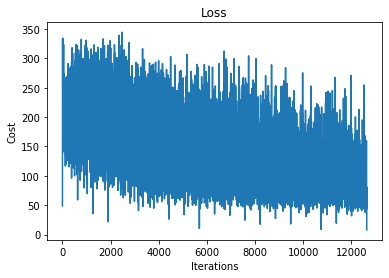

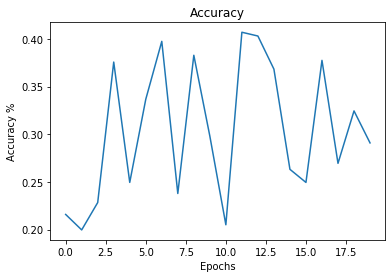


  Testing accuracy after training  0.26547956292998787 



In [7]:
plt.plot(range(num_of_iterations), iteration_losses)
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title('Loss')
plt.savefig('Results//Loss.png')
plt.show()

plt.plot(range(epochs), epoch_accuracies)
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.savefig('Results//Accuracy.png')
plt.show()


### Test the network with no training 
corrects, wrongs = nn.evaluate(test_imgs_np, testing_labels)
print("\n  Testing accuracy after training ", corrects / ( corrects + wrongs), '\n')

# Iterating over the learning rate

In [8]:
#set seed for reproducible results

rates =  [0.0001, 0.00015, 0.0002]

accuracies = [] # same lenght as rates

losses= [] # same lenght as rates

test_accuracies = []

np.random.seed(8)
np.random.RandomState(8)


for lr in rates:
    
    print(lr)
    
    nn = billy_nn( architecture = [2304,100,100,4], bias = False, activation = 'RELU', learning_rate = lr, momentum_rate = 0.4)    
    
    iteration_losses = [] 
    epoch_accuracies = []
    
    for epoch in range(epochs):

                # cycle through all minibatches of data
                n_samples = training_imgs_np.shape[0]
                #shuffle entire dataset indices for proper mini-batch GD
                indices = np.arange(training_imgs_np.shape[0])
                np.random.shuffle(indices)

                for start in range(0, n_samples, batch_size):

                      end = min (start + batch_size, n_samples)
                      batch_indices = indices[start:end]

                      #train nn on mini-batch data
                      nn.train_on_batch(training_imgs_np[batch_indices],training_labels_one_hot_np[batch_indices])

                      #save loss on the mini-batch
                      iteration_losses.append(nn.batch_loss)


                #Evaluate training accuracy after each iteration
                corrects, wrongs = nn.evaluate(training_imgs_np, training_labels) #this is the integer representation
                accu = corrects / ( corrects + wrongs)
                #print('_________________________________________________\n')
                #print("Training accuracy after epoch ", accu, '\n')
                epoch_accuracies.append(accu)

                #epoch completed 
                #print ("Epochs completed {} / {} ".format(epoch+1,epochs))
    
    accuracies.append(epoch_accuracies)   
    losses.append(iteration_losses)
    
    
    ### Test the network with no training 
    corrects, wrongs = nn.evaluate(test_imgs_np, testing_labels)
    print("\n  Testing accuracy after training ", corrects / ( corrects + wrongs), '\n')
    
    test_accuracies.append(corrects / ( corrects + wrongs))

    

0.0001

  Testing accuracy after training  0.4182517199514367 

0.00015

  Testing accuracy after training  0.396195872116552 

0.0002

  Testing accuracy after training  0.4105625252934035 



In [9]:
#
# Compare models
#

In [10]:
test_accuracies

[0.4182517199514367, 0.396195872116552, 0.4105625252934035]

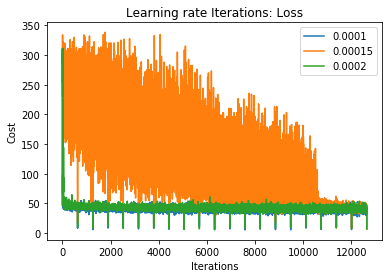

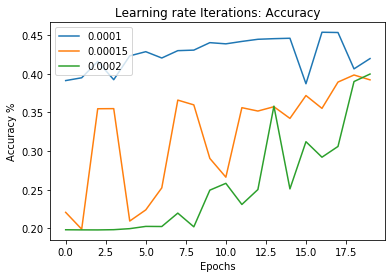

In [11]:
plt.plot(range(len(iteration_losses)), losses[0], label = "0.0001" )
plt.plot(range(len(iteration_losses)), losses[1], label = "0.00015")
plt.plot(range(len(iteration_losses)), losses[2], label = "0.0002")
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title('Learning rate Iterations: Loss')
plt.legend(loc = "upper right")
plt.savefig('Results//Comparing_losses.png')
plt.show()

plt.plot(range(epochs), accuracies[0], label = '0.0001')
plt.plot(range(epochs), accuracies[1], label = '0.00015')
plt.plot(range(epochs), accuracies[2], label = '0.0002')
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.title('Learning rate Iterations: Accuracy')
plt.legend(loc = "upper left")
plt.savefig('Results//Comparing_accuracies.png')
plt.show()


# Applying Dropout to the best model

In [8]:


class billy_nn_dropout:
    
      
      
      
    def linear_activation_batch(self,matrix):
          
          return matrix

      
    def relu_activation_batch(self,matrix):
          
          
          return np.maximum(0,matrix)
    
      
    def relu_derivative_batch(self, matrix):
          
        matrix[matrix<=0] = 0
        matrix[matrix>0] = 1
        
        return matrix
  
      

      
    def softmax_activation_batch(self, matrix):
          
        z = matrix - np.max(matrix, axis=-1, keepdims=True) #prevent overflow here, with this 
        numerator = np.exp(z)
        denominator = np.sum(numerator,1)
        denominator = denominator.reshape(matrix.shape[0],-1) # (number of samples, 1)
        
        probs = numerator/denominator
        
        return probs      
          



    
    
    def __init__(self, architecture = [1024, 100, 10] , bias = False, activation = 'RELU',  learning_rate = 0.0015, 
                 regularizer_l2 = False, L2_term = 0.005, dropout = False, dropout_rate = 0.5, momentum_rate = 0.4):
        
        self.bias = bias
        
        self.activation = activation
        
        self.architecture = architecture
        
        self.learning_rate = learning_rate
        
        self.regularizer_l2 = regularizer_l2
        
        self.L2_term = L2_term
        
        self.dropout = dropout
        
        self.dropout_rate = dropout_rate
        
        self.momentum_terms = []
        
        self.momentum_rate = momentum_rate
        
        self.initialize_weights() #initialize weights by taking into account the architecture
        
      
      
      
      
        
    def initialize_weights(self):
            
            self.weights = []
            self.biases = []
            
            #initialize weights for arbitrary lenght NN 
            
            for _ in range(len(self.architecture)-1):
                
                weight_matrix = np.random.normal(loc=0.0,scale=2/np.sqrt(self.architecture[_]+self.architecture[_+1]),
                                                 size=(self.architecture[_],self.architecture[_+1]))
                
                self.weights.append(weight_matrix)
                
                #biases = np.random.normal(loc=0.0, scale=1,size=(self.architecture[i+1]))





                #
                ## COST FUNCTION UNDER REVIEW 
                #
  
    def calculate_cost_batch(self, probs, labels):
          
          losses = labels * np.log(probs+ 1e-5) # works against underflow
          
          #losses
          
          batch_loss = - losses.sum()
          
          return batch_loss


        
        
    def train_on_batch(self, batch_samples, batch_labels):
        
        
          if self.dropout == False:
                
                batch_probs, hidden_activations = self.forward_batch_propagation(batch_samples)
          
          else:
                
                batch_probs, hidden_activations, activation_masks = self.forward_batch_propagation_dropout(batch_samples)
                      
          #calculate batch loss      
          batch_loss = self.calculate_cost_batch( batch_probs, batch_labels )
          self.batch_loss = batch_loss       
                
          ####update weights for the batch, first backpropagate the error, and then update each weight matrix
          if self.dropout == False : 
                
                self.update_weights_batch( batch_probs, hidden_activations, batch_labels, batch_samples )
                
          
          else:
                self.update_weights_batch_dropout( batch_probs, hidden_activations, batch_labels, batch_samples, activation_masks) 
                
                
          return True       
    
      
      
      
    def forward_batch_propagation_dropout(self,batch_samples):
                    
          activation_masks = [] 
          
          nn_layers = self.architecture[1:-1] # grab the dimensions of the hidden layers, excluding the first and last layers 
          
          
          for layer in nn_layers:
                
                activation_mask = (np.random.rand(batch_samples.shape[0],layer) < self.dropout_rate) / self.dropout_rate
                
                activation_masks.append(activation_mask)
                
         
         ## forward propagation using masks
         
         # 1. linear transformation 
         
         # 2. non-linear activation
         
         # 3. activation_mask application
         
          input_batch = batch_samples
          hidden_activations = [] # 
          
          mask_counter = 0
        
          for weight in self.weights:
            
              trans_batch = np.dot(input_batch, weight) #matrix multiplication, no biasses added
            
              if weight.shape[1] == 4: #if we are multipying the by the final weight matrix
                  #apply softmax activation to the batch
                  probabilities_batch = self.softmax_activation_batch(trans_batch)
                  break
                
                
              elif self.activation == 'RELU':   
                
                  output_batch = self.relu_activation_batch(trans_batch)
                  output_batch = output_batch * activation_masks[mask_counter] #dropout 
                  hidden_activations.append(output_batch)
                  
                  mask_counter += 1
                  
                
              elif self.activation == 'LINEAR':
                
                  output_batch = self.linear_activation_batch(trans_batch)
                  hidden_activations.append(output_batch)
        
              input_batch = output_batch
         
         
          
          return probabilities_batch, hidden_activations, activation_masks
    
      
      
      
      
      
    def update_weights_batch_dropout(self,batch_probs, hidden_activations,  batch_labels, batch_samples ,activation_masks) :
          
          
          hidden_activations.reverse()
          
          # error to propagate 
          output_layer_error = batch_probs - batch_labels 
          
          
          weights_list = list(self.weights)
          weights_list.reverse()
          
          
          
          layer_errors = []  
          layer_errors.append(output_layer_error.T)
                   
          error_l = output_layer_error     
          
          # back-prop using the activation masks for dropout
    
          for i in range(len(weights_list)-1):
                
                    
                error_term = np.dot(weights_list[i],error_l.T)
                
                derivative_term = self.relu_derivative_batch(hidden_activations[i].T)
                
                #element-wise multiplication for the full error expression
                error_l_minus = error_term * derivative_term
                
                layer_errors.append(error_l_minus)
                
                error_l = error_l_minus.T



          activations = list(hidden_activations)
          activations.reverse()
          
          activations.insert(0,batch_samples)
          activations.reverse()       
          
          
          ## weight updates using the hidden activations and layer error
          activation_masks.reverse()
          activation_masks.append( np.ones(batch_samples.shape)) 
          
          """
          
          for i in range(len(layer_errors)):
                
                masked_activation = activations[i] * activation_masks[mask_counter] 
                weight_update = np.dot(layer_errors[i], masked_activation)
                weights_list[i] -= self.learning_rate * weight_update.T #take some of the gradient using learning rate
                
                mask_counter += 1
          
          weights_list.reverse()
          """
          
          
          
          if not self.momentum_terms: #if momentum terms have not been set... use regular GD and save the weight updates for next time
                
                mask_counter = 0
          
                for i in range(len(layer_errors)):
                                            
                      masked_activation = activations[i] * activation_masks[mask_counter] 
                      
                      weight_update = np.dot(layer_errors[i], masked_activation)
                      
                      self.momentum_terms.append(weight_update)
                      
                      weights_list[i] -= self.learning_rate * weight_update.T 
                      
                      mask_counter += 1
                                      
                weights_list.reverse()
          

          else: # if the momentum terms DO exist, then use them for accelerating Gradient Descent!!!!!!!!
                
                momentum_terms = list(self.momentum_terms) 
                
                mask_counter = 0
               
                for i in range(len(layer_errors)):
                                            
                      masked_activation = activations[i] * activation_masks[mask_counter] 
                      
                      weight_update = np.dot(layer_errors[i], masked_activation)
                      

                      weight_update = (self.momentum_rate * momentum_terms[i]) + self.learning_rate * weight_update #momentum
                      
                                            
                      weights_list[i] -= weight_update.T  # weight update 
                      
                      momentum_terms[i] = weight_update # momentum update (keep a runnning average)
                      
                      mask_counter += 1


                                      
                weights_list.reverse()      
                self.weights = weights_list
                self.momentum_terms = momentum_terms          
        
          

          
    def forward_batch_propagation(self, batch_samples):
        
        # propagate the batch signal through the network, not using biases 
        input_batch = batch_samples
        hidden_activations = [] # needed for gradient calculation
        
        for weight in self.weights:
            
            trans_batch = np.dot(input_batch, weight) #matrix multiplication, no biasses added
            
            if weight.shape[1] == 4: 
                probabilities_batch = self.softmax_activation_batch(trans_batch)
                break
                
                
            elif self.activation == 'RELU':   
                
                output_batch = self.relu_activation_batch(trans_batch)
                hidden_activations.append(output_batch)
                #SAVE HIDDEN ACTIVATION
                
            elif self.activation == 'LINEAR':
                
                output_batch = self.linear_activation_batch(trans_batch)
                hidden_activations.append(output_batch)

                #SAVE HIDDEN ACTIVATION
                
            input_batch = output_batch
                
            
        
        return probabilities_batch, hidden_activations
                  
        
  

     
    def update_weights_batch(self, batch_probs, hidden_activations, batch_labels, batch_samples) :
          
          hidden_activations.reverse()
          
          output_layer_error = batch_probs - batch_labels # error to propagate 
          
          weights_list = list(self.weights)
          weights_list.reverse()
          
          
          layer_errors = []  # reverse this if needed
          
          layer_errors.append(output_layer_error.T)
         
          
          error_l = output_layer_error
          
          for i in range(len(weights_list)-1):
                
                error_term = np.dot(weights_list[i],error_l.T)
                
                derivative_term = self.relu_derivative_batch(hidden_activations[i].T)
                
                #element-wise multiplication for the full error expression
                error_l_minus = error_term * derivative_term
                
                layer_errors.append(error_l_minus)
                
                error_l = error_l_minus.T
                
                
          # layer errors created here. 
          
          # update weights here using the layer errors and the hidden activations 
          activations = list(hidden_activations)
          activations.reverse()
          
          activations.insert(0,batch_samples)
          activations.reverse()


          """
          for i in range(len(layer_errors)):
                
                weight_update = np.dot(layer_errors[i],activations[i])
                
                weights_list[i] -= self.learning_rate * weight_update.T #take some of the gradient using learning rate
                
          
          weights_list.reverse()
          
          self.weights = weights_list
          
          """
          
          
          ########## Momentum weight updates 
          
          

          if not self.momentum_terms: #if momentum terms have not been set... use regular GD and save the weight updates for next time
          
                for i in range(len(layer_errors)):
                                            
                      weight_gradient = np.dot(layer_errors[i],activations[i]) 
                      
                      weight_gradient = weight_gradient +  (self.L2_term * weights_list[i].T) #regularization term
                      
                      self.momentum_terms.append(weight_gradient)
                      
                      weights_list[i] -= self.learning_rate * weight_gradient.T 
                                      
                weights_list.reverse()
          

          else: # if the momentum terms DO exist, then use them for accelerating Gradient Descent!!!!!!!!
                
                momentum_terms = list(self.momentum_terms) 
               
                for i in range(len(layer_errors)):
                                            
                      weight_gradient = np.dot(layer_errors[i],activations[i])
                      
                                            
                      weight_gradient = weight_gradient +  (self.L2_term * weights_list[i].T) #regularization term

                      weight_update = (self.momentum_rate * momentum_terms[i]) + self.learning_rate * weight_gradient #momentum
                      
                                            
                      weights_list[i] -= weight_update.T 
                      
                      momentum_terms[i] = weight_update

                                      
                weights_list.reverse()      
                self.weights = weights_list
                self.momentum_terms = momentum_terms          
          

                
          
      
      
    def evaluate(self,data,labels):
        
        corrects, wrongs = 0, 0
        
        for i in range(len(data)):
              
            res = self.infer_sample(data[i])
            #sumaaaaaaaaaaaa = res.sum()
            res_max = res.argmax()
            #ruin=labels[i]
            
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs    




    def infer_sample(self,sample):
        #use this function to get a sample prediction, after the network has been trained   
        prediction = self.signal_propagation_test(sample)
          
        return prediction  
  
   
    def signal_propagation_test(self,sample):
                              
          trans_vector = sample
          
          for weight in self.weights:
                
                trans_vector = np.dot(trans_vector, weight) # matrix transformation 
                
                trans_vector = self.relu_activation_batch(trans_vector) # relu activation, no bias added
                
          prediction = trans_vector 
          
          return prediction
                
            
            
            
            
            
### Modelling

In [10]:
nn = billy_nn_dropout( architecture = [2304,100,100,4], bias = False, activation = 'RELU',  learning_rate = 0.0001, dropout = True,
              momentum_rate = 0.4, dropout_rate = 0.8)
iteration_losses = [] 
epoch_accuracies = []


In [11]:
#for each epoch 

#set seed for reproducible results

np.random.seed(1)
np.random.RandomState(1)


for epoch in range(epochs):

            # cycle through all minibatches of data
            n_samples = training_imgs_np.shape[0]
            #shuffle entire dataset indices for proper mini-batch GD
            indices = np.arange(training_imgs_np.shape[0])
            np.random.shuffle(indices)
            
            for start in range(0, n_samples, batch_size):
            
                  end = min (start + batch_size, n_samples)
                  batch_indices = indices[start:end]
                  
                  #train nn on mini-batch data
                  nn.train_on_batch(training_imgs_np[batch_indices],training_labels_one_hot_np[batch_indices])
                  
                  #save loss on the mini-batch
                  iteration_losses.append(nn.batch_loss)

            
            #Evaluate training accuracy after each iteration
            corrects, wrongs = nn.evaluate(training_imgs_np, training_labels) #this is the integer representation
            accu = corrects / ( corrects + wrongs)
            print('_________________________________________________\n')
            print("Training accuracy after epoch ", accu, '\n')
            epoch_accuracies.append(accu)
            
            #epoch completed 
            print ("Epochs completed {} / {} ".format(epoch+1,epochs))

_________________________________________________

Training accuracy after epoch  0.1976928408753342 

Epochs completed 1 / 20 
_________________________________________________

Training accuracy after epoch  0.1976928408753342 

Epochs completed 2 / 20 
_________________________________________________

Training accuracy after epoch  0.1976928408753342 

Epochs completed 3 / 20 
_________________________________________________

Training accuracy after epoch  0.1975938211704129 

Epochs completed 4 / 20 
_________________________________________________

Training accuracy after epoch  0.1976928408753342 

Epochs completed 5 / 20 
_________________________________________________

Training accuracy after epoch  0.19739578176057035 

Epochs completed 6 / 20 
_________________________________________________

Training accuracy after epoch  0.19764333102287354 

Epochs completed 7 / 20 
_________________________________________________

Training accuracy after epoch  0.19764333102287354 

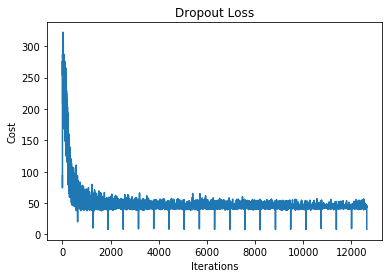

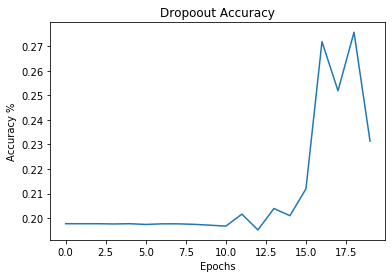

In [12]:
plt.plot(range(num_of_iterations), iteration_losses)
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title('Dropout Loss')
plt.savefig('Results//Dropout_Loss.png')
plt.show()

plt.plot(range(epochs), epoch_accuracies)
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.title('Dropoout Accuracy')
plt.savefig('Results//Dropout_Accuracy.png')
plt.show()


In [13]:
### Test the network with no training 
corrects, wrongs = nn.evaluate(test_imgs_np, testing_labels)
print("\n  Testing accuracy after training ", corrects / ( corrects + wrongs), '\n')


  Testing accuracy after training  0.23249696479158236 



## End of Notebook